In [1]:
import torch
import data
import tqdm
import models
import numpy as np
import json
import rgan
from PIL import Image
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Loading the configuration file, which contains information about the simulated images, and the telescopes they were modelled on, and some model hyperparameters

In [2]:
with open('../config.json') as config_file:
    config = json.load(config_file)

In [ ]:
EPOCHS = 100
LR = 5e-5 
IN_SHAPE = config["image_shape_2"] # image dimensions in pixels (assuming square image)
MAGNIFICATION = config["magnification"] # magnitude of each magnification
N_MAG = config["n_magnification"] # number of magnifications required to be performed
DELTA = config["resolution_3"] # LR image resolution
alpha_t_scaling = config["alpha_t_scaling"] # scaling coefficient of the tangential component of the deflection angle 
VDL_WEIGHT = 0.75 # initial vdl weight

### Scaling the deflection angle obtained from the SISR models:
The deflection angle values are obtained by design as $\alpha(x,y) \in (0,1)$. They are thus rescaled within appropriate bounds before their use for the purpose of lensing. The coefficients 1 and 2 correspond to the radial $\alpha_r(x,y)$ and tangential $\alpha_t(x,y)$ components of the deflection angle. While $\alpha_r(x,y)$ can ideally be used to contain all the pertaining information, this is no longer required ot be true, as the image space is discretized to pixels. To account for potential inaccuracies brought by this discretization, a (smaller) $\alpha_t(x,y)$ is used for the purpose of potential correction.

In [3]:
alpha_bounds = [config["alpha_l"],config["alpha_h"]] # bounds for the deflection angle, used in it's scaling

alpha_coeff_1 = torch.tensor(alpha_bounds[1]-alpha_bounds[0]).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_coeff_2 = torch.tensor((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_coeff = torch.concat([alpha_coeff_1, alpha_coeff_2],dim=1)

alpha_disp_1 = torch.tensor(alpha_bounds[0]).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_disp_2 = torch.tensor(-((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling)/2).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_disp = torch.concat([alpha_disp_1, alpha_disp_2],dim=1)

def alpha_scaling(alpha):
    """
    Scales the deflection angle obtained from the model to meaningful bounds
    
    :param alpha: Deflection angle to be scaled
    :return: Scaled deflection angle
    """
    alpha = alpha * alpha_coeff.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    alpha = alpha + alpha_disp.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    return alpha

### Loading the datasets, the dataloaders and performing the required train:validation partitions
A batch size of 5 (merely for computational convenience) is used 5000 images for training, which is divided by an 80:20 validation split. The 5000 images are derived more-or-less equally from the three DM sub-structure classes. There are no high-resolution images loaded as they are not needed !

In [4]:
# We can now load the datasets, combine and shuffle them to have a (close to) homogenous distribution of all sub-structures.
BATCH_SIZE = 5 # Feel free to increase this number; all the training was done on my personal machine, hence, this limitation/

dataset_no_sub = data.LensingDataset('../../Simulations/data_model_3/',['no_sub'],5000)
train_dataset_no_sub, val_dataset_no_sub = torch.utils.data.random_split(dataset_no_sub, [0.8, 0.2])

dataset_axion = data.LensingDataset('../../Simulations/data_model_3/',['axion'],5000)
train_dataset_axion, val_dataset_axion = torch.utils.data.random_split(dataset_axion, [0.8, 0.2])

dataset_cdm = data.LensingDataset('../../Simulations/data_model_3/',['cdm'],5000)
train_dataset_cdm, val_dataset_cdm = torch.utils.data.random_split(dataset_cdm, [0.8, 0.2])

train_dataset = torch.utils.data.ConcatDataset([train_dataset_no_sub, train_dataset_axion, train_dataset_cdm])
val_dataset = torch.utils.data.ConcatDataset([val_dataset_no_sub, val_dataset_axion, val_dataset_cdm])

train_dataset, train_rest = torch.utils.data.random_split(train_dataset, [0.34, 0.66])
val_dataset, val_rest = torch.utils.data.random_split(val_dataset, [0.34, 0.66])

train_dataloader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)
val_dataloader = torch.utils.data.DataLoader(val_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)

# This configuration will load 5000 (low-resolution) images in total, with a 80:20 validation split. 

### Models and physics-inspired loss function loading

In [5]:
# We construct and load the SISR model to the GPU (if available). A loss module is also loaded that performs all the operations required during training.

alpha_model = models.SISR(magnification=MAGNIFICATION, n_mag=N_MAG, residual_depth=config["alpha_depth"], in_channels=1, latent_channel_count=config["latent_channels"]).to(device)
disc_models = [rgan.Discriminator(residual_depth=4, in_shape=IN_SHAPE*MAGNIFICATION*N_MAG, latent_channel_count=8).to(device),
               rgan.Discriminator(residual_depth=4, in_shape=IN_SHAPE, latent_channel_count=8).to(device),
               rgan.Discriminator(residual_depth=4, in_shape=IN_SHAPE//(MAGNIFICATION*N_MAG), latent_channel_count=8).to(device),]
lens_loss = models.SersicProfiler(resolution=DELTA, device=device, discriminators=disc_models, sersic_args = [1, 1, 0.25], vdl_weight=VDL_WEIGHT)

opt = torch.optim.Adam(params=alpha_model.parameters(),lr=LR)
alpha_params = sum(p.numel() for p in alpha_model.parameters())
print(f"Generator network parameters: {alpha_params/1e6}1e6")
param_list = []
for model in disc_models:
    param_list += list(model.parameters())
disc_opt = torch.optim.Adam(params=param_list,lr=LR)
for i,model in zip(range(3),disc_models):
    params = sum(p.numel() for p in model.parameters())
    print(f"Discriminator network {i} parameters: {params/1e6}e6")

Generator network parameters: 0.9004221e6
Discriminator network 0 parameters: 0.149425e6
Discriminator network 1 parameters: 0.051121e6
Discriminator network 2 parameters: 0.026545e6


### Performing weight initialization
Several studies have shown that model weight initialization can help in more effective convergence.

In [6]:
# Performing He initialization of the model weights.

def init_weights(m):
    """
    Iterates through all the convolution and fully connected layers of the model to initialize all their weights

    :param m: Model to be initialized
    """
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight)  # He initialization
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

alpha_model.apply(init_weights)

SISR(
  (residual_layer_list): ModuleList(
    (0-2): 3 x Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (subpixel_layer_list): ModuleList(
    (0): Sequential(
      (0): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): PixelShuffle(upscale_factor=2)
      (2): ReLU()
    )
  )
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv3): Conv2d(64, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2

### Defining functions that sample the model's performance

In [7]:
def give_random_image(dataset, alpha_model, length, i=None, plot=True):
    """
    Provides a random image for evaluation

    :param dataset: Dataset used
    :param alpha_model: Model used
    :param length: Length of dataset used
    :param i: Index of the selected image, default: 
    :param plot: If true, also plots the source fitting graphs
    :return: original LR image, SR image, reconstructed source
    """
    if i == None:
        i = np.random.randint(low=0,high=length)
    LR = dataset[i].view(1,1,IN_SHAPE,IN_SHAPE).float()
    alpha = alpha_scaling(alpha_model(LR.float().to(device)).detach())
    sersic_profile, LR, source_profile = lens_loss.get_sample(alpha.to(device), LR.to(device), plot)
    LR_im = Image.fromarray(LR.cpu().detach().numpy()[0]*255)
    sersic_im = Image.fromarray(sersic_profile.cpu().detach().numpy()[0]*255)
    source_im = Image.fromarray(source_profile.cpu().detach().numpy()[0]*255)
    return (LR_im, sersic_im, source_im)

def show_random_image(image_tuple):
    """
    Displays the images provided by the give_random_image function
    
    :param image_tuple: Tuple of images returned by the give_random_image function
    """
    LR_im, sersic_im, source_im = image_tuple[0], image_tuple[1], image_tuple[2]
    plot, axes = plt.subplots(1,3)
    plot.set_size_inches(18,6)
    axes[0].imshow(LR_im)
    axes[1].imshow(sersic_im)
    axes[2].imshow(source_im)
    axes[0].set_title("LR_interpolated")
    axes[1].set_title("Image")
    axes[2].set_title("Source Profile")

/home/ashankar/Documents/Work/.env/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


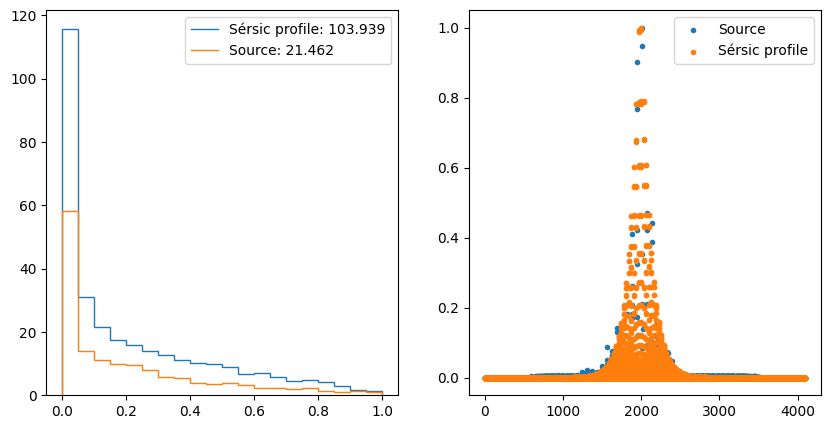

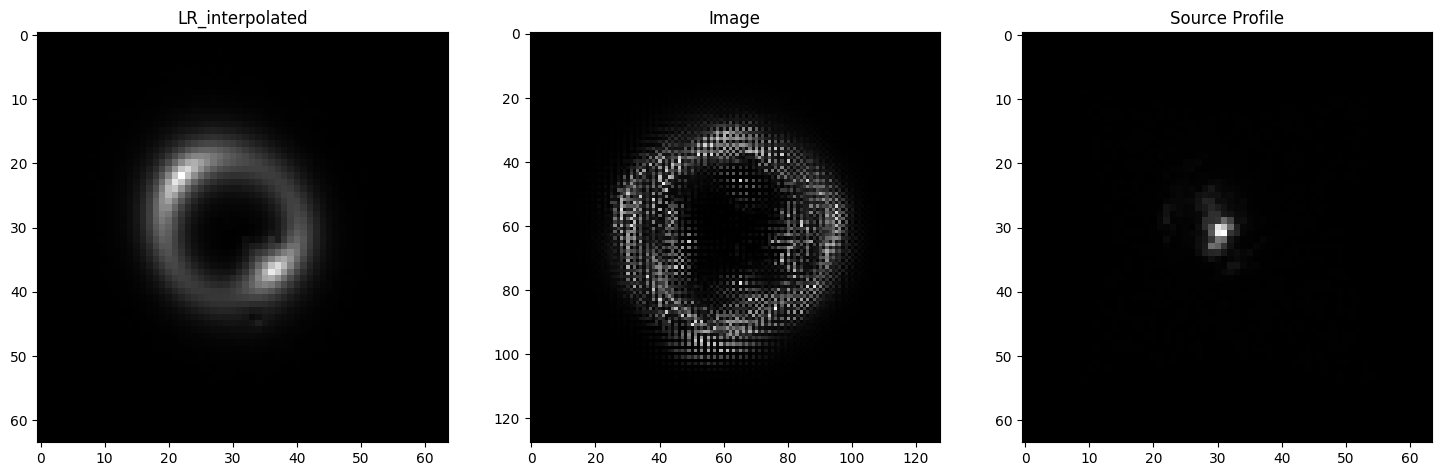

In [8]:
show_random_image(give_random_image(val_dataset, alpha_model, len(val_dataset)))

### The training sequence
The model is trained over the set number of epochs over the training images, and subsequently validated on the validation set. For both, the deflection angle given by the model is used to perform lensing, and is trained in an unsupervised manner by imposing the lensing system's constraints. Since the loss module is composed of various components, each of them is tracked for further study if required.

In [9]:
# Training Sequence

best_val_loss = np.inf
best_weights = None
history = {'val_loss':[], 'loss':[], 'images':[], 'lr':[], 'source':[], 'ad_loss':[], 'ad_val_loss':[]} # tracks the train and val losses and training results at each epoch
history_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]} # tracks the individual train loss components at each epoch
for epoch in range(EPOCHS):
    losses = []
    ad_losses = []
    alpha_model.train()
    for model in disc_models:
        model.train()
    individual_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]}
    for i,(x) in enumerate(tqdm.tqdm(train_dataloader, desc=f"Training epoch {epoch+1}")):
        (x) = (x.float().to(device))
        alpha = alpha_model(x)
        alpha = alpha_scaling(alpha)
        loss, history_individual, ad_loss = lens_loss(alpha, x)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(float(loss))
        disc_opt.zero_grad()
        ad_loss.backward()
        disc_opt.step()
        ad_losses.append(float(ad_loss))
        for key in individual_losses.keys():
            if history_individual[key] != None:
                individual_losses[key].append(float(history_individual[key]))
            else:
                individual_losses[key].append(None)
    for key in individual_losses.keys():
        if individual_losses[key][-1] != None:
            history_losses[key].append(np.mean(individual_losses[key]))
        else:
            history_losses[key].append(None)
    if np.isnan(losses[-1]): 
        break
    print(f"Training at epoch {epoch+1}/{EPOCHS}: {np.mean(losses) - float(np.mean(individual_losses['alpha_0']))} at LR={opt.param_groups[0]['lr']}")
    history['loss'].append(np.mean(losses) - float(np.mean(individual_losses['alpha_0'])))
    history['ad_loss'].append(np.mean(ad_losses))
    alpha_model.eval()
    for model in disc_models:
        model.eval()
    individual_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]}
    losses = []
    ad_losses = []
    for i,(x) in enumerate(tqdm.tqdm(val_dataloader, desc=f"Validation epoch {epoch+1}")):
        (x) = (x.float().to(device))
        alpha = alpha_scaling(alpha_model(x))
        val_loss, history_individual, ad_val_loss = lens_loss(alpha, x)
        losses.append(float(val_loss))
        ad_losses.append(float(ad_val_loss))
        for key in individual_losses.keys():
            if history_individual[key] != None:
                individual_losses[key].append(float(history_individual[key]))
            else:
                individual_losses[key].append(None)
    if best_val_loss > np.mean(losses):
        best_val_loss = np.mean(losses)
        best_weights = alpha_model.state_dict()
    history['val_loss'].append(np.mean(losses) - float(np.mean(individual_losses['alpha_0'])))
    history['ad_val_loss'].append(np.mean(ad_losses))
    print(f"Validation at epoch {epoch+1}/{EPOCHS}: {np.mean(losses) - float(np.mean(individual_losses['alpha_0']))} at LR={opt.param_groups[0]['lr']}")
    lr, im, sr = give_random_image(val_dataset, alpha_model, len(val_dataset),50, plot=False)
    history['lr'].append(lr)
    history['images'].append(im)
    history['source'].append(sr)
    lens_loss.decay_vdl(DECAY)

Training epoch 1: 100%|██████████| 816/816 [00:50<00:00, 16.14it/s]


Training at epoch 1/100: 0.021960409942503076 at LR=5e-05


Validation epoch 1: 100%|██████████| 204/204 [00:06<00:00, 33.95it/s]


Validation at epoch 1/100: 0.022611671949134153 at LR=5e-05


Training epoch 2: 100%|██████████| 816/816 [00:50<00:00, 16.07it/s]


Training at epoch 2/100: 0.01938938611762269 at LR=5e-05


Validation epoch 2: 100%|██████████| 204/204 [00:06<00:00, 32.78it/s]


Validation at epoch 2/100: 0.01511124548200956 at LR=5e-05


Training epoch 3: 100%|██████████| 816/816 [00:52<00:00, 15.67it/s]


Training at epoch 3/100: 0.014810810871102718 at LR=5e-05


Validation epoch 3: 100%|██████████| 204/204 [00:06<00:00, 32.66it/s]


Validation at epoch 3/100: 0.013945106672597865 at LR=5e-05


Training epoch 4: 100%|██████████| 816/816 [00:51<00:00, 15.90it/s]


Training at epoch 4/100: 0.013221804202675784 at LR=5e-05


Validation epoch 4: 100%|██████████| 204/204 [00:06<00:00, 33.77it/s]


Validation at epoch 4/100: 0.01256571838908427 at LR=5e-05


Training epoch 5: 100%|██████████| 816/816 [00:50<00:00, 16.19it/s]


Training at epoch 5/100: 0.012091339441408933 at LR=5e-05


Validation epoch 5: 100%|██████████| 204/204 [00:06<00:00, 33.50it/s]


Validation at epoch 5/100: 0.012070299473741802 at LR=5e-05


Training epoch 6: 100%|██████████| 816/816 [00:50<00:00, 16.18it/s]


Training at epoch 6/100: 0.011384468576151822 at LR=5e-05


Validation epoch 6: 100%|██████████| 204/204 [00:06<00:00, 32.27it/s]


Validation at epoch 6/100: 0.01115932344007032 at LR=5e-05


Training epoch 7: 100%|██████████| 816/816 [00:50<00:00, 16.02it/s]


Training at epoch 7/100: 0.010763387685395118 at LR=5e-05


Validation epoch 7: 100%|██████████| 204/204 [00:06<00:00, 33.98it/s]


Validation at epoch 7/100: 0.009733798048532038 at LR=5e-05


Training epoch 8: 100%|██████████| 816/816 [00:52<00:00, 15.66it/s]


Training at epoch 8/100: 0.010295413719837132 at LR=5e-05


Validation epoch 8: 100%|██████████| 204/204 [00:06<00:00, 32.97it/s]


Validation at epoch 8/100: 0.010065120794095885 at LR=5e-05


Training epoch 9: 100%|██████████| 816/816 [00:53<00:00, 15.14it/s]


Training at epoch 9/100: 0.009922786050546896 at LR=5e-05


Validation epoch 9: 100%|██████████| 204/204 [00:06<00:00, 33.59it/s]


Validation at epoch 9/100: 0.009994468473950309 at LR=5e-05


Training epoch 10: 100%|██████████| 816/816 [00:52<00:00, 15.63it/s]


Training at epoch 10/100: 0.009131865341937644 at LR=5e-05


Validation epoch 10: 100%|██████████| 204/204 [00:06<00:00, 33.32it/s]


Validation at epoch 10/100: 0.008814663649936133 at LR=5e-05


Training epoch 11: 100%|██████████| 816/816 [00:51<00:00, 15.74it/s]


Training at epoch 11/100: 0.008159946592344317 at LR=5e-05


Validation epoch 11: 100%|██████████| 204/204 [00:06<00:00, 33.53it/s]


Validation at epoch 11/100: 0.007956285181731516 at LR=5e-05


Training epoch 12: 100%|██████████| 816/816 [00:51<00:00, 15.95it/s]


Training at epoch 12/100: 0.007328678354764742 at LR=5e-05


Validation epoch 12: 100%|██████████| 204/204 [00:06<00:00, 33.60it/s]


Validation at epoch 12/100: 0.007370217731388002 at LR=5e-05


Training epoch 13: 100%|██████████| 816/816 [00:51<00:00, 15.84it/s]


Training at epoch 13/100: 0.006531129529535332 at LR=5e-05


Validation epoch 13: 100%|██████████| 204/204 [00:06<00:00, 32.43it/s]


Validation at epoch 13/100: 0.006556394089962922 at LR=5e-05


Training epoch 14: 100%|██████████| 816/816 [00:50<00:00, 16.04it/s]


Training at epoch 14/100: 0.0060293928285782205 at LR=5e-05


Validation epoch 14: 100%|██████████| 204/204 [00:06<00:00, 33.79it/s]


Validation at epoch 14/100: 0.006223255767134318 at LR=5e-05


Training epoch 15: 100%|██████████| 816/816 [00:50<00:00, 16.24it/s]


Training at epoch 15/100: 0.005382956786585661 at LR=5e-05


Validation epoch 15: 100%|██████████| 204/204 [00:05<00:00, 34.22it/s]


Validation at epoch 15/100: 0.005215018565222101 at LR=5e-05


Training epoch 16: 100%|██████████| 816/816 [00:50<00:00, 16.23it/s]


Training at epoch 16/100: 0.00471586191327101 at LR=5e-05


Validation epoch 16: 100%|██████████| 204/204 [00:06<00:00, 33.46it/s]


Validation at epoch 16/100: 0.004594736735681163 at LR=5e-05


Training epoch 17: 100%|██████████| 816/816 [00:49<00:00, 16.35it/s]


Training at epoch 17/100: 0.0043917248978829655 at LR=5e-05


Validation epoch 17: 100%|██████████| 204/204 [00:06<00:00, 33.94it/s]


Validation at epoch 17/100: 0.004317210615423106 at LR=5e-05


Training epoch 18: 100%|██████████| 816/816 [00:50<00:00, 16.22it/s]


Training at epoch 18/100: 0.004237549281599202 at LR=5e-05


Validation epoch 18: 100%|██████████| 204/204 [00:05<00:00, 34.54it/s]


Validation at epoch 18/100: 0.004065108953321161 at LR=5e-05


Training epoch 19: 100%|██████████| 816/816 [00:50<00:00, 16.29it/s]


Training at epoch 19/100: 0.003716225078724343 at LR=5e-05


Validation epoch 19: 100%|██████████| 204/204 [00:05<00:00, 34.32it/s]


Validation at epoch 19/100: 0.00367304255475984 at LR=5e-05


Training epoch 20: 100%|██████████| 816/816 [00:50<00:00, 16.27it/s]


Training at epoch 20/100: 0.003295154374962508 at LR=5e-05


Validation epoch 20: 100%|██████████| 204/204 [00:06<00:00, 33.67it/s]


Validation at epoch 20/100: 0.0031934766732007905 at LR=5e-05


Training epoch 21: 100%|██████████| 816/816 [00:50<00:00, 16.24it/s]


Training at epoch 21/100: 0.0031580448392596015 at LR=5e-05


Validation epoch 21: 100%|██████████| 204/204 [00:05<00:00, 34.45it/s]


Validation at epoch 21/100: 0.0030461282400281956 at LR=5e-05


Training epoch 22: 100%|██████████| 816/816 [00:50<00:00, 16.31it/s]


Training at epoch 22/100: 0.003165668713479011 at LR=5e-05


Validation epoch 22: 100%|██████████| 204/204 [00:06<00:00, 34.00it/s]


Validation at epoch 22/100: 0.0031622711465780756 at LR=5e-05


Training epoch 23: 100%|██████████| 816/816 [00:49<00:00, 16.38it/s]


Training at epoch 23/100: 0.00292066466685284 at LR=5e-05


Validation epoch 23: 100%|██████████| 204/204 [00:05<00:00, 34.37it/s]


Validation at epoch 23/100: 0.0030655494840318045 at LR=5e-05


Training epoch 24: 100%|██████████| 816/816 [00:50<00:00, 16.20it/s]


Training at epoch 24/100: 0.0027552241275164606 at LR=5e-05


Validation epoch 24: 100%|██████████| 204/204 [00:06<00:00, 33.67it/s]


Validation at epoch 24/100: 0.0030438233679531404 at LR=5e-05


Training epoch 25: 100%|██████████| 816/816 [00:50<00:00, 16.16it/s]


Training at epoch 25/100: 0.0026296744074309516 at LR=5e-05


Validation epoch 25: 100%|██████████| 204/204 [00:06<00:00, 33.54it/s]


Validation at epoch 25/100: 0.0026767106643163455 at LR=5e-05


Training epoch 26: 100%|██████████| 816/816 [00:50<00:00, 16.25it/s]


Training at epoch 26/100: 0.0025488357745880245 at LR=5e-05


Validation epoch 26: 100%|██████████| 204/204 [00:05<00:00, 34.16it/s]


Validation at epoch 26/100: 0.0026731796561387665 at LR=5e-05


Training epoch 27: 100%|██████████| 816/816 [00:50<00:00, 16.12it/s]


Training at epoch 27/100: 0.002614513634220131 at LR=5e-05


Validation epoch 27: 100%|██████████| 204/204 [00:05<00:00, 34.16it/s]


Validation at epoch 27/100: 0.0026409733568560152 at LR=5e-05


Training epoch 28: 100%|██████████| 816/816 [00:50<00:00, 16.24it/s]


Training at epoch 28/100: 0.002489333394966225 at LR=5e-05


Validation epoch 28: 100%|██████████| 204/204 [00:06<00:00, 33.70it/s]


Validation at epoch 28/100: 0.002584827786788582 at LR=5e-05


Training epoch 29: 100%|██████████| 816/816 [00:50<00:00, 16.23it/s]


Training at epoch 29/100: 0.0026108879623386785 at LR=5e-05


Validation epoch 29: 100%|██████████| 204/204 [00:05<00:00, 34.46it/s]


Validation at epoch 29/100: 0.0027324068136045294 at LR=5e-05


Training epoch 30: 100%|██████████| 816/816 [00:50<00:00, 16.16it/s]


Training at epoch 30/100: 0.0024746459701632645 at LR=5e-05


Validation epoch 30: 100%|██████████| 204/204 [00:06<00:00, 33.18it/s]


Validation at epoch 30/100: 0.0025534572002167506 at LR=5e-05


Training epoch 31: 100%|██████████| 816/816 [00:50<00:00, 16.25it/s]


Training at epoch 31/100: 0.002436482355822627 at LR=5e-05


Validation epoch 31: 100%|██████████| 204/204 [00:05<00:00, 34.38it/s]


Validation at epoch 31/100: 0.0025395874733529873 at LR=5e-05


Training epoch 32: 100%|██████████| 816/816 [00:50<00:00, 16.24it/s]


Training at epoch 32/100: 0.002600528540057769 at LR=5e-05


Validation epoch 32: 100%|██████████| 204/204 [00:05<00:00, 34.36it/s]


Validation at epoch 32/100: 0.0025315996425014616 at LR=5e-05


Training epoch 33: 100%|██████████| 816/816 [00:50<00:00, 16.16it/s]


Training at epoch 33/100: 0.0027475059294945325 at LR=5e-05


Validation epoch 33: 100%|██████████| 204/204 [00:05<00:00, 34.45it/s]


Validation at epoch 33/100: 0.0025763170001571805 at LR=5e-05


Training epoch 34: 100%|██████████| 816/816 [00:50<00:00, 16.28it/s]


Training at epoch 34/100: 0.002515222461250447 at LR=5e-05


Validation epoch 34: 100%|██████████| 204/204 [00:06<00:00, 33.74it/s]


Validation at epoch 34/100: 0.002475341956026158 at LR=5e-05


Training epoch 35: 100%|██████████| 816/816 [00:50<00:00, 16.23it/s]


Training at epoch 35/100: 0.0024740179154939725 at LR=5e-05


Validation epoch 35: 100%|██████████| 204/204 [00:06<00:00, 33.59it/s]


Validation at epoch 35/100: 0.0027785627308356403 at LR=5e-05


Training epoch 36: 100%|██████████| 816/816 [00:50<00:00, 16.26it/s]


Training at epoch 36/100: 0.0025205128962018843 at LR=5e-05


Validation epoch 36: 100%|██████████| 204/204 [00:05<00:00, 34.60it/s]


Validation at epoch 36/100: 0.0025540717547033534 at LR=5e-05


Training epoch 37: 100%|██████████| 816/816 [00:50<00:00, 16.26it/s]


Training at epoch 37/100: 0.002412540467191196 at LR=5e-05


Validation epoch 37: 100%|██████████| 204/204 [00:05<00:00, 34.02it/s]


Validation at epoch 37/100: 0.002483108615064446 at LR=5e-05


Training epoch 38: 100%|██████████| 816/816 [00:50<00:00, 16.17it/s]


Training at epoch 38/100: 0.0025581856835724826 at LR=5e-05


Validation epoch 38: 100%|██████████| 204/204 [00:06<00:00, 33.69it/s]


Validation at epoch 38/100: 0.0026077909906413056 at LR=5e-05


Training epoch 39: 100%|██████████| 816/816 [00:50<00:00, 16.18it/s]


Training at epoch 39/100: 0.0025797611340428427 at LR=5e-05


Validation epoch 39: 100%|██████████| 204/204 [00:06<00:00, 33.52it/s]


Validation at epoch 39/100: 0.0025466605584369972 at LR=5e-05


Training epoch 40: 100%|██████████| 816/816 [00:50<00:00, 16.14it/s]


Training at epoch 40/100: 0.002492827539932548 at LR=5e-05


Validation epoch 40: 100%|██████████| 204/204 [00:06<00:00, 33.92it/s]


Validation at epoch 40/100: 0.0025056522204335227 at LR=5e-05


Training epoch 41: 100%|██████████| 816/816 [00:50<00:00, 16.12it/s]


Training at epoch 41/100: 0.0025320589609727183 at LR=5e-05


Validation epoch 41: 100%|██████████| 204/204 [00:05<00:00, 34.27it/s]


Validation at epoch 41/100: 0.0025260680989709263 at LR=5e-05


Training epoch 42: 100%|██████████| 816/816 [00:50<00:00, 16.13it/s]


Training at epoch 42/100: 0.0023931832635985207 at LR=5e-05


Validation epoch 42: 100%|██████████| 204/204 [00:05<00:00, 34.20it/s]


Validation at epoch 42/100: 0.0024627169113955456 at LR=5e-05


Training epoch 43: 100%|██████████| 816/816 [00:50<00:00, 16.32it/s]


Training at epoch 43/100: 0.002550733337343177 at LR=5e-05


Validation epoch 43: 100%|██████████| 204/204 [00:05<00:00, 34.11it/s]


Validation at epoch 43/100: 0.002799112621384362 at LR=5e-05


Training epoch 44: 100%|██████████| 816/816 [00:50<00:00, 16.21it/s]


Training at epoch 44/100: 0.0026085941944449364 at LR=5e-05


Validation epoch 44: 100%|██████████| 204/204 [00:05<00:00, 34.31it/s]


Validation at epoch 44/100: 0.002616035635476104 at LR=5e-05


Training epoch 45: 100%|██████████| 816/816 [00:50<00:00, 16.29it/s]


Training at epoch 45/100: 0.0026721722953131095 at LR=5e-05


Validation epoch 45: 100%|██████████| 204/204 [00:05<00:00, 34.31it/s]


Validation at epoch 45/100: 0.0033922439963812497 at LR=5e-05


Training epoch 46: 100%|██████████| 816/816 [00:50<00:00, 16.18it/s]


Training at epoch 46/100: 0.002757962576687728 at LR=5e-05


Validation epoch 46: 100%|██████████| 204/204 [00:05<00:00, 34.04it/s]


Validation at epoch 46/100: 0.00250321867276273 at LR=5e-05


Training epoch 47: 100%|██████████| 816/816 [00:50<00:00, 16.23it/s]


Training at epoch 47/100: 0.0025956375199408886 at LR=5e-05


Validation epoch 47: 100%|██████████| 204/204 [00:06<00:00, 33.75it/s]


Validation at epoch 47/100: 0.0026257902315289057 at LR=5e-05


Training epoch 48: 100%|██████████| 816/816 [00:50<00:00, 16.24it/s]


Training at epoch 48/100: 0.0025858151664793043 at LR=5e-05


Validation epoch 48: 100%|██████████| 204/204 [00:05<00:00, 34.34it/s]


Validation at epoch 48/100: 0.00253742905539077 at LR=5e-05


Training epoch 49: 100%|██████████| 816/816 [00:50<00:00, 16.24it/s]


Training at epoch 49/100: 0.002592819535707616 at LR=5e-05


Validation epoch 49: 100%|██████████| 204/204 [00:06<00:00, 33.58it/s]


Validation at epoch 49/100: 0.002658308386005457 at LR=5e-05


Training epoch 50: 100%|██████████| 816/816 [00:50<00:00, 16.21it/s]


Training at epoch 50/100: 0.0025444798465126526 at LR=5e-05


Validation epoch 50: 100%|██████████| 204/204 [00:05<00:00, 34.18it/s]


Validation at epoch 50/100: 0.00262040759569608 at LR=5e-05


Training epoch 51: 100%|██████████| 816/816 [00:50<00:00, 16.15it/s]


Training at epoch 51/100: 0.002485150394290138 at LR=5e-05


Validation epoch 51: 100%|██████████| 204/204 [00:06<00:00, 33.71it/s]


Validation at epoch 51/100: 0.002526295410158733 at LR=5e-05


Training epoch 52: 100%|██████████| 816/816 [00:50<00:00, 16.14it/s]


Training at epoch 52/100: 0.0023950838896744956 at LR=5e-05


Validation epoch 52: 100%|██████████| 204/204 [00:05<00:00, 34.21it/s]


Validation at epoch 52/100: 0.0024546170737035113 at LR=5e-05


Training epoch 53: 100%|██████████| 816/816 [00:50<00:00, 16.21it/s]


Training at epoch 53/100: 0.0023996488036537623 at LR=5e-05


Validation epoch 53: 100%|██████████| 204/204 [00:05<00:00, 34.04it/s]


Validation at epoch 53/100: 0.0024476631572492896 at LR=5e-05


Training epoch 54: 100%|██████████| 816/816 [00:50<00:00, 16.16it/s]


Training at epoch 54/100: 0.0024296330649282456 at LR=5e-05


Validation epoch 54: 100%|██████████| 204/204 [00:06<00:00, 33.58it/s]


Validation at epoch 54/100: 0.002489934917535078 at LR=5e-05


Training epoch 55: 100%|██████████| 816/816 [00:50<00:00, 16.15it/s]


Training at epoch 55/100: 0.0023885822112217786 at LR=5e-05


Validation epoch 55: 100%|██████████| 204/204 [00:06<00:00, 33.97it/s]


Validation at epoch 55/100: 0.002460483336072488 at LR=5e-05


Training epoch 56: 100%|██████████| 816/816 [00:50<00:00, 16.29it/s]


Training at epoch 56/100: 0.002367731202884541 at LR=5e-05


Validation epoch 56: 100%|██████████| 204/204 [00:05<00:00, 34.20it/s]


Validation at epoch 56/100: 0.0024490308637991 at LR=5e-05


Training epoch 57: 100%|██████████| 816/816 [00:50<00:00, 16.19it/s]


Training at epoch 57/100: 0.0023947674231820596 at LR=5e-05


Validation epoch 57: 100%|██████████| 204/204 [00:06<00:00, 33.86it/s]


Validation at epoch 57/100: 0.002475604526219232 at LR=5e-05


Training epoch 58: 100%|██████████| 816/816 [00:50<00:00, 16.24it/s]


Training at epoch 58/100: 0.0023696820225107816 at LR=5e-05


Validation epoch 58: 100%|██████████| 204/204 [00:06<00:00, 33.85it/s]


Validation at epoch 58/100: 0.00246245005109813 at LR=5e-05


Training epoch 59: 100%|██████████| 816/816 [00:50<00:00, 16.31it/s]


Training at epoch 59/100: 0.0023697107927885142 at LR=5e-05


Validation epoch 59: 100%|██████████| 204/204 [00:05<00:00, 34.10it/s]


Validation at epoch 59/100: 0.002434357430091969 at LR=5e-05


Training epoch 60: 100%|██████████| 816/816 [00:50<00:00, 16.16it/s]


Training at epoch 60/100: 0.0023391458899805363 at LR=5e-05


Validation epoch 60: 100%|██████████| 204/204 [00:06<00:00, 33.52it/s]


Validation at epoch 60/100: 0.0024394298602333844 at LR=5e-05


Training epoch 61: 100%|██████████| 816/816 [00:50<00:00, 16.21it/s]


Training at epoch 61/100: 0.00234093433862333 at LR=5e-05


Validation epoch 61: 100%|██████████| 204/204 [00:05<00:00, 34.78it/s]


Validation at epoch 61/100: 0.002440706947727093 at LR=5e-05


Training epoch 62: 100%|██████████| 816/816 [00:50<00:00, 16.10it/s]


Training at epoch 62/100: 0.0023430688475034947 at LR=5e-05


Validation epoch 62: 100%|██████████| 204/204 [00:05<00:00, 34.29it/s]


Validation at epoch 62/100: 0.002436625451653027 at LR=5e-05


Training epoch 63: 100%|██████████| 816/816 [00:50<00:00, 16.24it/s]


Training at epoch 63/100: 0.002340697312462783 at LR=5e-05


Validation epoch 63: 100%|██████████| 204/204 [00:05<00:00, 34.02it/s]


Validation at epoch 63/100: 0.0024399178441586525 at LR=5e-05


Training epoch 64: 100%|██████████| 816/816 [00:50<00:00, 16.17it/s]


Training at epoch 64/100: 0.0023424442219145613 at LR=5e-05


Validation epoch 64: 100%|██████████| 204/204 [00:05<00:00, 34.08it/s]


Validation at epoch 64/100: 0.002430262353157684 at LR=5e-05


Training epoch 65: 100%|██████████| 816/816 [00:50<00:00, 16.23it/s]


Training at epoch 65/100: 0.002346574601414789 at LR=5e-05


Validation epoch 65: 100%|██████████| 204/204 [00:06<00:00, 33.78it/s]


Validation at epoch 65/100: 0.0024302384911428186 at LR=5e-05


Training epoch 66: 100%|██████████| 816/816 [00:50<00:00, 16.22it/s]


Training at epoch 66/100: 0.0023425748512073204 at LR=5e-05


Validation epoch 66: 100%|██████████| 204/204 [00:05<00:00, 34.03it/s]


Validation at epoch 66/100: 0.002433260005809348 at LR=5e-05


Training epoch 67: 100%|██████████| 816/816 [00:50<00:00, 16.18it/s]


Training at epoch 67/100: 0.0023397723664094847 at LR=5e-05


Validation epoch 67: 100%|██████████| 204/204 [00:06<00:00, 33.57it/s]


Validation at epoch 67/100: 0.0024316125738109468 at LR=5e-05


Training epoch 68: 100%|██████████| 816/816 [00:50<00:00, 16.21it/s]


Training at epoch 68/100: 0.00234063204148693 at LR=5e-05


Validation epoch 68: 100%|██████████| 204/204 [00:05<00:00, 34.24it/s]


Validation at epoch 68/100: 0.0024283486603048727 at LR=5e-05


Training epoch 69: 100%|██████████| 816/816 [00:50<00:00, 16.17it/s]


Training at epoch 69/100: 0.002336820434719337 at LR=5e-05


Validation epoch 69: 100%|██████████| 204/204 [00:06<00:00, 33.81it/s]


Validation at epoch 69/100: 0.002428345230857123 at LR=5e-05


Training epoch 70: 100%|██████████| 816/816 [00:50<00:00, 16.13it/s]


Training at epoch 70/100: 0.002338580584238638 at LR=5e-05


Validation epoch 70: 100%|██████████| 204/204 [00:06<00:00, 33.40it/s]


Validation at epoch 70/100: 0.002432567067871695 at LR=5e-05


Training epoch 71: 100%|██████████| 816/816 [00:50<00:00, 16.17it/s]


Training at epoch 71/100: 0.0023391536931878926 at LR=5e-05


Validation epoch 71: 100%|██████████| 204/204 [00:05<00:00, 34.74it/s]


Validation at epoch 71/100: 0.0024297655791318466 at LR=5e-05


Training epoch 72: 100%|██████████| 816/816 [00:50<00:00, 16.16it/s]


Training at epoch 72/100: 0.002339637470043919 at LR=5e-05


Validation epoch 72: 100%|██████████| 204/204 [00:06<00:00, 33.42it/s]


Validation at epoch 72/100: 0.0024291315362436937 at LR=5e-05


Training epoch 73: 100%|██████████| 816/816 [00:50<00:00, 16.18it/s]


Training at epoch 73/100: 0.002340745878225084 at LR=5e-05


Validation epoch 73: 100%|██████████| 204/204 [00:06<00:00, 33.49it/s]


Validation at epoch 73/100: 0.0024325639925186684 at LR=5e-05


Training epoch 74: 100%|██████████| 816/816 [00:50<00:00, 16.27it/s]


Training at epoch 74/100: 0.0023405262371195266 at LR=5e-05


Validation epoch 74: 100%|██████████| 204/204 [00:06<00:00, 33.80it/s]


Validation at epoch 74/100: 0.0024316165341977188 at LR=5e-05


Training epoch 75: 100%|██████████| 816/816 [00:53<00:00, 15.12it/s]


Training at epoch 75/100: 0.002337922996047066 at LR=5e-05


Validation epoch 75: 100%|██████████| 204/204 [00:07<00:00, 28.89it/s]


Validation at epoch 75/100: 0.002429114217764912 at LR=5e-05


Training epoch 76: 100%|██████████| 816/816 [00:56<00:00, 14.50it/s]


Training at epoch 76/100: 0.0023362420793521265 at LR=5e-05


Validation epoch 76: 100%|██████████| 204/204 [00:06<00:00, 29.18it/s]


Validation at epoch 76/100: 0.002428350823966854 at LR=5e-05


Training epoch 77: 100%|██████████| 816/816 [00:56<00:00, 14.53it/s]


Training at epoch 77/100: 0.00233867940969173 at LR=5e-05


Validation epoch 77: 100%|██████████| 204/204 [00:06<00:00, 29.65it/s]


Validation at epoch 77/100: 0.0024283521633776148 at LR=5e-05


Training epoch 78: 100%|██████████| 816/816 [00:55<00:00, 14.59it/s]


Training at epoch 78/100: 0.0023372500173905637 at LR=5e-05


Validation epoch 78: 100%|██████████| 204/204 [00:06<00:00, 30.15it/s]


Validation at epoch 78/100: 0.002427721217330955 at LR=5e-05


Training epoch 79: 100%|██████████| 816/816 [00:56<00:00, 14.49it/s]


Training at epoch 79/100: 0.00233904261139276 at LR=5e-05


Validation epoch 79: 100%|██████████| 204/204 [00:06<00:00, 29.79it/s]


Validation at epoch 79/100: 0.002428346233292277 at LR=5e-05


Training epoch 80: 100%|██████████| 816/816 [00:57<00:00, 14.18it/s]


Training at epoch 80/100: 0.002338269257971806 at LR=5e-05


Validation epoch 80: 100%|██████████| 204/204 [00:06<00:00, 29.58it/s]


Validation at epoch 80/100: 0.0024288090853241857 at LR=5e-05


Training epoch 81: 100%|██████████| 816/816 [00:55<00:00, 14.60it/s]


Training at epoch 81/100: 0.002337753220432445 at LR=5e-05


Validation epoch 81: 100%|██████████| 204/204 [00:06<00:00, 30.81it/s]


Validation at epoch 81/100: 0.0024366985327999822 at LR=5e-05


Training epoch 82: 100%|██████████| 816/816 [00:56<00:00, 14.57it/s]


Training at epoch 82/100: 0.002341470364051739 at LR=5e-05


Validation epoch 82: 100%|██████████| 204/204 [00:06<00:00, 30.12it/s]


Validation at epoch 82/100: 0.002431613815803042 at LR=5e-05


Training epoch 83: 100%|██████████| 816/816 [00:57<00:00, 14.27it/s]


Training at epoch 83/100: 0.002340022594358281 at LR=5e-05


Validation epoch 83: 100%|██████████| 204/204 [00:07<00:00, 29.12it/s]


Validation at epoch 83/100: 0.002428347491044245 at LR=5e-05


Training epoch 84: 100%|██████████| 816/816 [00:57<00:00, 14.24it/s]


Training at epoch 84/100: 0.0023373667009660036 at LR=5e-05


Validation epoch 84: 100%|██████████| 204/204 [00:07<00:00, 29.13it/s]


Validation at epoch 84/100: 0.0024283558112697993 at LR=5e-05


Training epoch 85: 100%|██████████| 816/816 [00:56<00:00, 14.53it/s]


Training at epoch 85/100: 0.0023366035270825565 at LR=5e-05


Validation epoch 85: 100%|██████████| 204/204 [00:06<00:00, 29.29it/s]


Validation at epoch 85/100: 0.002428347777776243 at LR=5e-05


Training epoch 86: 100%|██████████| 816/816 [00:55<00:00, 14.79it/s]


Training at epoch 86/100: 0.002339362185692696 at LR=5e-05


Validation epoch 86: 100%|██████████| 204/204 [00:06<00:00, 29.43it/s]


Validation at epoch 86/100: 0.002429122350733198 at LR=5e-05


Training epoch 87: 100%|██████████| 816/816 [00:56<00:00, 14.55it/s]


Training at epoch 87/100: 0.0023373831361218037 at LR=5e-05


Validation epoch 87: 100%|██████████| 204/204 [00:06<00:00, 29.82it/s]


Validation at epoch 87/100: 0.002428358824468518 at LR=5e-05


Training epoch 88: 100%|██████████| 816/816 [00:56<00:00, 14.44it/s]


Training at epoch 88/100: 0.0023367579482517545 at LR=5e-05


Validation epoch 88: 100%|██████████| 204/204 [00:06<00:00, 30.48it/s]


Validation at epoch 88/100: 0.0024297705982005806 at LR=5e-05


Training epoch 89: 100%|██████████| 816/816 [00:55<00:00, 14.60it/s]


Training at epoch 89/100: 0.0023385163602218564 at LR=5e-05


Validation epoch 89: 100%|██████████| 204/204 [00:07<00:00, 28.94it/s]


Validation at epoch 89/100: 0.0024283428898358725 at LR=5e-05


Training epoch 90: 100%|██████████| 816/816 [00:56<00:00, 14.37it/s]


Training at epoch 90/100: 0.0023372143450080245 at LR=5e-05


Validation epoch 90: 100%|██████████| 204/204 [00:06<00:00, 29.43it/s]


Validation at epoch 90/100: 0.0024291220932626035 at LR=5e-05


Training epoch 91: 100%|██████████| 816/816 [00:57<00:00, 14.18it/s]


Training at epoch 91/100: 0.002340432980191996 at LR=5e-05


Validation epoch 91: 100%|██████████| 204/204 [00:07<00:00, 29.09it/s]


Validation at epoch 91/100: 0.0024283443956240286 at LR=5e-05


Training epoch 92: 100%|██████████| 816/816 [00:56<00:00, 14.35it/s]


Training at epoch 92/100: 0.002336213673579386 at LR=5e-05


Validation epoch 92: 100%|██████████| 204/204 [00:07<00:00, 28.00it/s]


Validation at epoch 92/100: 0.0024316162207953956 at LR=5e-05


Training epoch 93: 100%|██████████| 816/816 [00:56<00:00, 14.35it/s]


Training at epoch 93/100: 0.002338314908124809 at LR=5e-05


Validation epoch 93: 100%|██████████| 204/204 [00:07<00:00, 28.83it/s]


Validation at epoch 93/100: 0.0024283446544037975 at LR=5e-05


Training epoch 94: 100%|██████████| 816/816 [00:57<00:00, 14.23it/s]


Training at epoch 94/100: 0.002339836528311983 at LR=5e-05


Validation epoch 94: 100%|██████████| 204/204 [00:07<00:00, 28.80it/s]


Validation at epoch 94/100: 0.00242770630126968 at LR=5e-05


Training epoch 95: 100%|██████████| 816/816 [00:58<00:00, 14.05it/s]


Training at epoch 95/100: 0.0023387785403795234 at LR=5e-05


Validation epoch 95: 100%|██████████| 204/204 [00:06<00:00, 29.39it/s]


Validation at epoch 95/100: 0.0024297588215889993 at LR=5e-05


Training epoch 96: 100%|██████████| 816/816 [00:57<00:00, 14.31it/s]


Training at epoch 96/100: 0.0023377454416331988 at LR=5e-05


Validation epoch 96: 100%|██████████| 204/204 [00:06<00:00, 29.20it/s]


Validation at epoch 96/100: 0.002428819732134748 at LR=5e-05


Training epoch 97: 100%|██████████| 816/816 [00:57<00:00, 14.21it/s]


Training at epoch 97/100: 0.0023397487231267963 at LR=5e-05


Validation epoch 97: 100%|██████████| 204/204 [00:07<00:00, 29.00it/s]


Validation at epoch 97/100: 0.002427702893821657 at LR=5e-05


Training epoch 98: 100%|██████████| 816/816 [00:56<00:00, 14.33it/s]


Training at epoch 98/100: 0.0023390992789372915 at LR=5e-05


Validation epoch 98: 100%|██████████| 204/204 [00:07<00:00, 27.85it/s]


Validation at epoch 98/100: 0.0024288063512579315 at LR=5e-05


Training epoch 99: 100%|██████████| 816/816 [00:56<00:00, 14.37it/s]


Training at epoch 99/100: 0.0023364346856856928 at LR=5e-05


Validation epoch 99: 100%|██████████| 204/204 [00:07<00:00, 28.77it/s]


Validation at epoch 99/100: 0.002427712280053127 at LR=5e-05


Training epoch 100: 100%|██████████| 816/816 [00:57<00:00, 14.31it/s]


Training at epoch 100/100: 0.002335886222278593 at LR=5e-05


Validation epoch 100: 100%|██████████| 204/204 [00:07<00:00, 28.18it/s]

Validation at epoch 100/100: 0.0024283447578087687 at LR=5e-05


Text(0.5, 1.0, 'Individual losses plot')

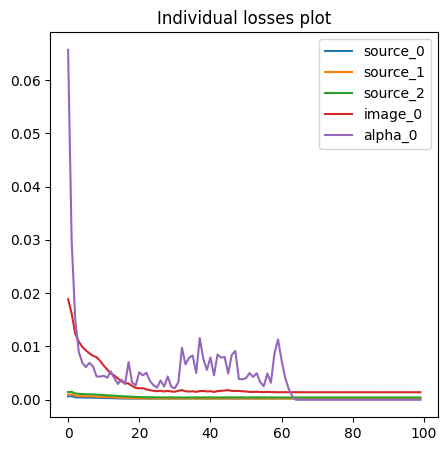

In [10]:
plot, axes = plt.subplots(1,1)
plot.set_size_inches(5,5)
for key in list(individual_losses.keys()):
    axes.plot(history_losses[key],label=key)
axes.legend()
axes.set_title('Individual losses plot')

Text(0.5, 1.0, 'Train and val losses')

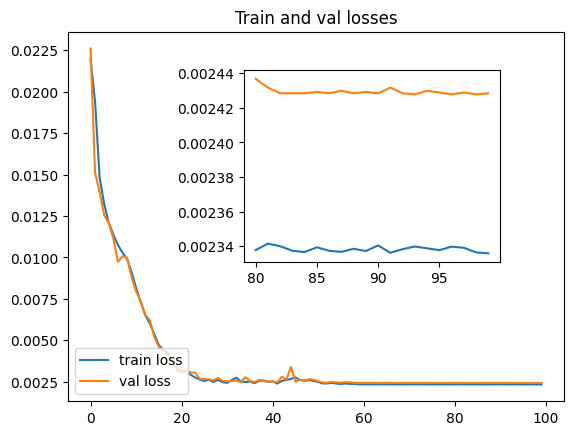

In [11]:
plot, axes = plt.subplots()
axes.plot(history['loss'],label='train loss')
axes.plot(history['val_loss'],label='val loss')
axes_2 = plot.add_axes([0.4,0.4,0.4,0.4])
axes_2.plot(range(int(0.8*EPOCHS),EPOCHS),history['loss'][int(0.8*EPOCHS):],label='train loss')
axes_2.plot(range(int(0.8*EPOCHS),EPOCHS),history['val_loss'][int(0.8*EPOCHS):],label='val loss')
# axes_2.set_xticks([int(0.8*EPOCHS), EPOCHS])
axes.legend(loc='lower left')
axes.set_title('Train and val losses')

### Loading the best performing model

In [12]:
# Loads the model weights at the lowest validation score

alpha_model.load_state_dict(best_weights)
print(best_val_loss)

0.0024277808477956


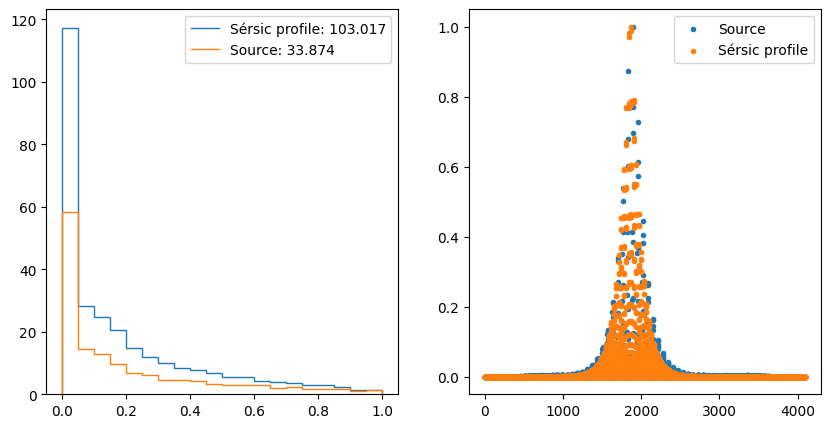

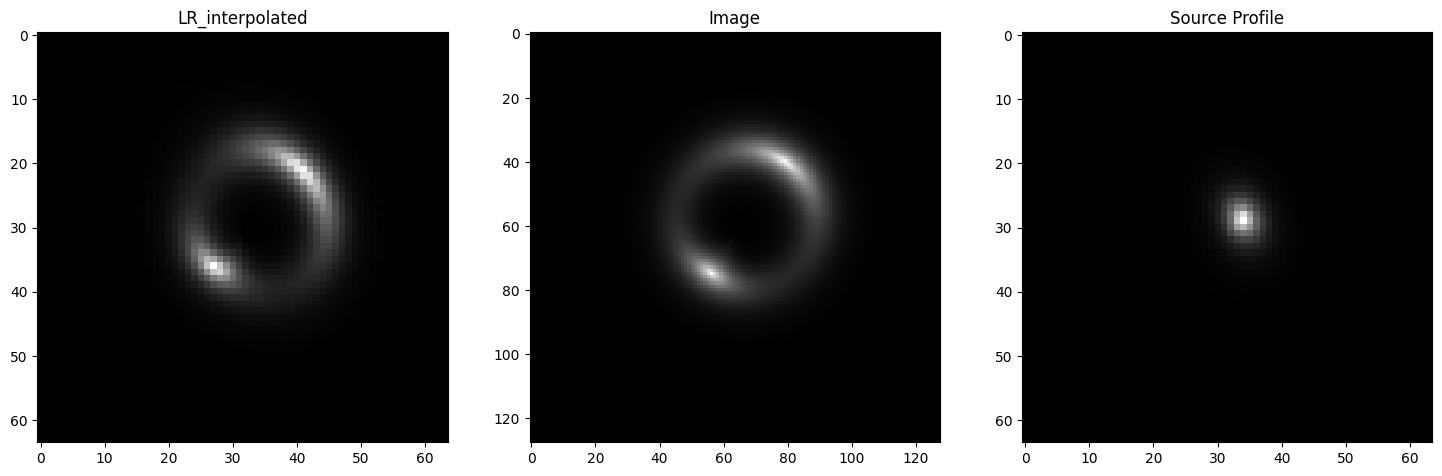

In [13]:
show_random_image(give_random_image(val_dataset, alpha_model, len(val_dataset)))

In [14]:
# Saves the training progress as GIFs of the reconstructed source and the super-resolved images

history['images'][0].save('images.gif',save_all=True, append_images = history['images'][1:], optimize=False, duration=100, loop=0)
history['lr'][0].save('lr.gif',save_all=True, append_images = history['lr'][1:], optimize=False, duration=100, loop=0)
history['source'][0].save('source.gif',save_all=True, append_images = history['source'][1:], optimize=False, duration=100, loop=0)

In [15]:
torch.save(best_weights, 'Weights_3.pt')